# Training an Object Segmentation Workshop
### By: Aaron Gabrielle C. Dichoso
### From: DLSU - Center of Imaging and Visual Innovations (CIVI)
May 27, 2025

## 1. Importing Libraries

In [13]:
import torch
import torchvision
from torchvision.datasets import CocoDetection
from torchvision.models.segmentation import fcn_resnet50
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask

## 2. Notebook configurations
Batch Size: The Number of Images passed to the model during training in one forward pass

Classes: Subset of 12 objects + 1 background class from the standard MSCOCO classes

["dog", "cat", "person", "chair", "mouse", "remote", "keyboard", "cell phone", "cup", "fork", "knife", "spoon"]

Epochs: Number of Iterations that the training images will be passed to the model.

Learning Rate: Affects the strength of adjustments applied to the model during training.

Device: Use CUDA if available, else use the CPU

In [14]:
BATCH_SIZE = 4
NUM_CLASSES = 12 + 1
NUM_EPOCHS = 45
LEARNING_RATE = 1e-3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

COCO_PATH = './dataset/'
TRAIN_IMG_DIR = os.path.join(COCO_PATH, 'coco_sample/train')
TEST_IMG_DIR = os.path.join(COCO_PATH, 'coco_sample/test')
VAL_IMG_DIR = os.path.join(COCO_PATH, 'coco_sample/val')
TRAIN_ANN_FILE = os.path.join(COCO_PATH, 'coco_sample/train.json')
TEST_ANN_FILE = os.path.join(COCO_PATH, 'coco_sample/test.json')
VAL_ANN_FILE = os.path.join(COCO_PATH, 'coco_sample/val.json')

## 3. Dataset Loader

A dataset loader is utilized in this notebook to allow modifications to the original MSCOCO dataset:

1. Instead of the 91 classes in MSCOCO, only 13 classes are used
2. Allows you to apply transformations to images before loading the image

In [15]:
class CocoSegmentation(torch.utils.data.Dataset):
    def __init__(self, root, annFile):
        self.root = root
        self.coco = COCO(annFile)
        self.ids = list(self.coco.imgs.keys())
        self.cat_ids = self.coco.getCatIds()
        print(self.cat_ids)
        self.class_names = {c['id']: c['name'] for c in self.coco.loadCats(self.cat_ids)}
        self.target_size = (480, 640)  # (height, width)
        self.cat_id_to_index = {cat_id: idx + 1 for idx, cat_id in enumerate(self.cat_ids)}


    def __getitem__(self, idx):
        img_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        img_info = self.coco.loadImgs(img_id)[0]

        # Load and resize image
        path = img_info['file_name']
        img_path = os.path.join(self.root, path)
        img = Image.open(img_path).convert('RGB')
        img = F.resize(img, self.target_size)
        img_tensor = F.to_tensor(img)

        # Create and resize semantic mask
        height, width = img_info['height'], img_info['width']
        mask = np.zeros((height, width), dtype=np.uint8)

        for ann in anns:
            if 'segmentation' in ann and isinstance(ann['segmentation'], list):
                rles = coco_mask.frPyObjects(ann['segmentation'], height, width)
                rle = coco_mask.merge(rles)
                m = coco_mask.decode(rle)
                class_idx = self.cat_id_to_index.get(ann['category_id'], 0)
                mask[m == 1] = class_idx

        # Resize mask to match resized image
        mask = Image.fromarray(mask)
        mask = F.resize(mask, self.target_size, interpolation=Image.NEAREST)
        mask_tensor = torch.as_tensor(np.array(mask), dtype=torch.long)

        return img_tensor, mask_tensor

    def __len__(self):
        return len(self.ids)

## 4. Load Datasets

In [16]:
train_dataset = CocoSegmentation(TRAIN_IMG_DIR, TRAIN_ANN_FILE)
test_dataset = CocoSegmentation(TEST_IMG_DIR, TEST_ANN_FILE)
val_dataset = CocoSegmentation(VAL_IMG_DIR, VAL_ANN_FILE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
[1, 17, 18, 47, 48, 49, 50, 62, 74, 75, 76, 77]
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
[1, 17, 18, 47, 48, 49, 50, 62, 74, 75, 76, 77]
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[1, 17, 18, 47, 48, 49, 50, 62, 74, 75, 76, 77]


## 5. FCN Model Configurations

Get the FCN model from pytorch, and modify it to use the custom number of classes

In [17]:
model = fcn_resnet50(pretrained=False, num_classes=NUM_CLASSES)
model.to(DEVICE)

C:\Users\Aaron\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Aaron\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

Criterion: Measure of Model Performance used during training.

Optimizer: Method used to determine the optimal weights during training.

Scheduler: Decays the Learning Rate over epochs

In [18]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

## 6. Training Loop

General Flow is as follows:
1. Set the model into training mode
2. For each epoch, do the following:
    a. Load the Images and Masks to the Device
    b. Zero out existing gradients
    c. Perform a Forward Pass
    d. Compute the Prediction Performance / Loss
    e. Perform a backward pass and update weights (Backpropagation)
    f. save the model checkpoint

In [19]:
from tqdm import tqdm
import os
import torch

def train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    if not os.path.exists("checkpoints"):
        os.makedirs("checkpoints")  # Create a directory to save checkpoints

    best_val_loss = float('inf')

    for epoch in range(num_epochs):  # For each epoch
        model.train()
        total_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for images, masks in progress_bar:
            images, masks = images.to(device), masks.to(device)  # Load Images and Masks to Device

            optimizer.zero_grad()  # Zero existing Gradients Just in Case
            outputs = model(images)['out']  # Forward Pass
            loss = criterion(outputs, masks)  # Compute Prediction Loss
            loss.backward()  # Backward Pass and Updating Weights
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}")

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False)
            for val_images, val_masks in val_bar:
                val_images, val_masks = val_images.to(device), val_masks.to(device)
                val_outputs = model(val_images)['out']
                loss_val = criterion(val_outputs, val_masks)
                val_loss += loss_val.item()
                val_bar.set_postfix(val_loss=loss_val.item())

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}")

        # Step the scheduler
        scheduler.step()

        # Save model checkpoint
        checkpoint_path = f"checkpoints/checkpoint_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_path = "checkpoints/best_model.pth"
            torch.save(model.state_dict(), best_path)
            print(f"Best model saved with val loss: {best_val_loss:.4f}")


In [ ]:
train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
    device=DEVICE,
)

NameError: name 'val_oader' is not defined

## 7. Evaluation Metrics

In [ ]:
def pixel_accuracy(preds, labels):
    valid = labels >= 0
    correct = (preds == labels) & valid
    return correct.sum().item() / valid.sum().item()

def mean_iou(preds, labels, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        label_inds = (labels == cls)
        intersection = (pred_inds & label_inds).sum().item()
        union = (pred_inds | label_inds).sum().item()
        if union > 0:
            ious.append(intersection / union)
    return sum(ious) / len(ious) if ious else 0.0

In [ ]:
def evaluate(model, dataloader):
    model.eval()
    accs, ious = [], []
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)['out']
            preds = torch.argmax(outputs, dim=1)

            accs.append(pixel_accuracy(preds.cpu(), masks.cpu()))
            ious.append(mean_iou(preds.cpu(), masks.cpu(), NUM_CLASSES))

    print(f"Pixel Accuracy: {np.mean(accs):.4f}")
    print(f"Mean IoU: {np.mean(ious):.4f}")

In [ ]:
evaluate(model, test_loader)

Pixel Accuracy: 0.9164
Mean IoU: 0.4916


## 8. Visualization

In [ ]:
import random
import torch.nn.functional as FNN

def visualize_random_samples(model, dataset, class_names, num_samples=5):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)

    for idx in indices:
        image, mask = dataset[idx]
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(DEVICE))['out']  # shape: (1, C, H, W)
            probs = FNN.softmax(output, dim=1).squeeze(0)          # shape: (C, H, W)
            pred = torch.argmax(probs, dim=0).cpu().numpy()      # shape: (H, W)
            # Calculate average confidence for each predicted class in the mask
            unique_labels = np.unique(pred)
            confs = {}
            for label in unique_labels:
                mask_pixels = (pred == label)
                # Average confidence for that class at predicted pixels
                conf = probs[label][mask_pixels].mean().item()
                confs[label] = conf

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title("Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred)
        plt.title("Prediction")
        plt.axis('off')

        plt.show()

        print(f"Sample index: {idx}")
        print("Class labels in prediction and average confidence:")
        for label in unique_labels:
            name = class_names.get(label, "N/A")
            confidence = confs[label]
            print(f"Label {label}: {name} - Confidence: {confidence:.3f}")
        print("-" * 30)


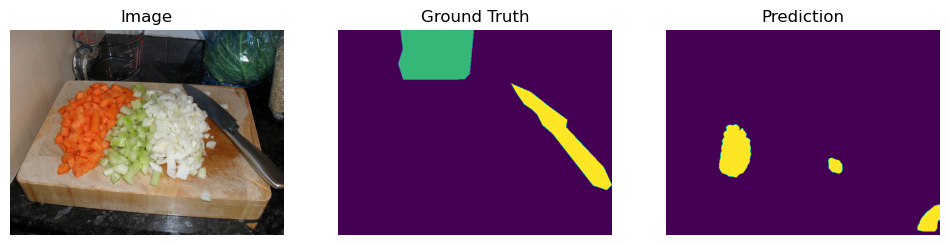

Sample index: 30
Class labels in prediction and average confidence:
Label 0: N/A - Confidence: 0.820
Label 1: person - Confidence: 0.678
------------------------------


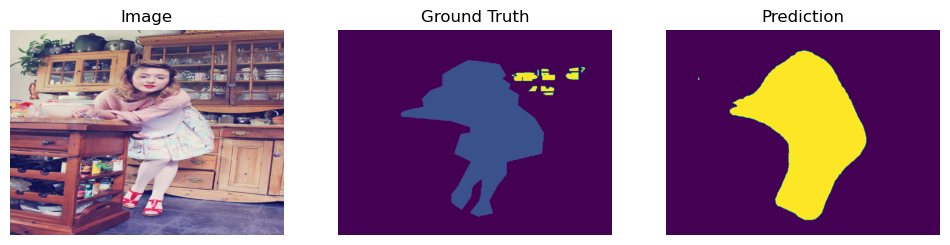

Sample index: 20
Class labels in prediction and average confidence:
Label 0: N/A - Confidence: 0.661
Label 1: person - Confidence: 0.855
------------------------------


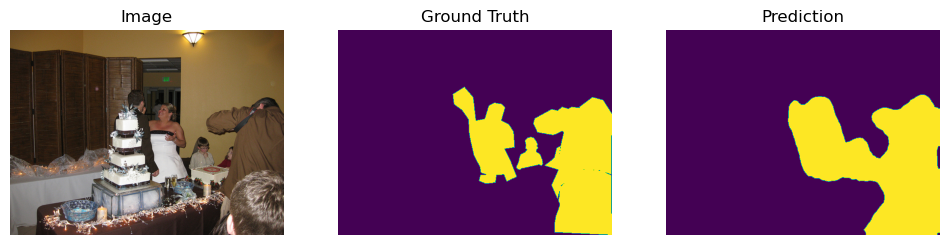

Sample index: 10
Class labels in prediction and average confidence:
Label 0: N/A - Confidence: 0.762
Label 1: person - Confidence: 0.815
------------------------------


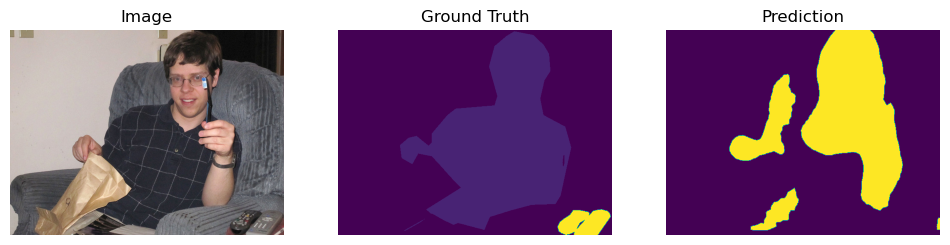

Sample index: 36
Class labels in prediction and average confidence:
Label 0: N/A - Confidence: 0.726
Label 1: person - Confidence: 0.806
------------------------------


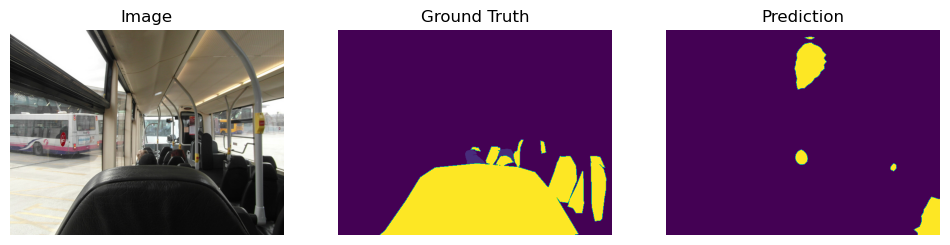

Sample index: 7
Class labels in prediction and average confidence:
Label 0: N/A - Confidence: 0.694
Label 1: person - Confidence: 0.525
------------------------------


In [ ]:
visualize_random_samples(model, test_dataset, test_dataset.class_names, 5)